### Imports

In [21]:
from lavis.models import model_zoo, load_model_and_preprocess
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import cv2
import pytesseract
from manga_ocr import MangaOcr
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import pyuac
import importlib
import sys
from openai import OpenAI
import openai
import pandas as pd
import time
import deepl

print(model_zoo)

# load captioning model. 
# To change to your customized weights, change pretrained attribute in BLIP2-Japanese\lavis\configs\models\blip2\blip2_pretrain.yaml
caption_model, visual_encoder, text_encoder = load_model_and_preprocess('blip2_Japanese', 'finetune') #load_model_and_preprocess('blip2_Japanese', 'pretrain')

# class for dataset 
class SampleDataset(Dataset):

    def __init__(self, img_root, visual_processor) -> None:
        super().__init__()
        self.img_root = img_root
        self.imgs = os.listdir(img_root)
        self.visual_processor = visual_processor

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image_name = self.imgs[index]
        image_path = os.path.join(self.img_root, image_name)
        raw_image = Image.open(image_path).convert("RGB")
        image = self.visual_processor(raw_image)

        return { "image" : image.unsqueeze(0), "name": image_name, "raw": raw_image}

c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Architectures                  Types
blip_pretrain                  base
blip2_Japanese_feature_extractor pretrain, finetune
blip2_Japanese                 pretrain, finetune


## Thesis Code

#### ChatGPT Set Up

In [2]:
# API Key stored in a different file
from openai_api_key import DeepL_api_key
# Init ChatGPT
openai.api_key = chatgpt_api_key
api_constraints = 20
def get_completion(prompt, model="gpt-3.5-turbo"):

    messages = [{"role": "user", "content": prompt}]

    # response = openai.ChatCompletion.create(model=model, messages=messages, temperature=0,)
    
    completion = openai.chat.completions.create(model=model, messages=messages)

    return completion.choices[0].message.content

#### DeepL SetUp

In [3]:
# API Key stored in a different file
from deepl_api_key import deepl_api_key
deepl_translator = deepl.Translator(deepl_api_key)

def deepl_translate(text: str):
    result = deepl_translator.translate_text(text, source_lang="JA", target_lang="EN-US")
    return result

# print(deepl_translate("ああとはじめさんがモデルのキャラクターのデザインできたんですよ"))

#### Helsinki Translator from Huggingface

In [5]:
# Initialize Translator
model_name = 'Helsinki-NLP/opus-mt-ja-en'
tokenizer = AutoTokenizer.from_pretrained(model_name)
trans_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
translator = pipeline("translation", model=trans_model, tokenizer=tokenizer)

max_len_limit = 1000

#### MangaOCR

In [4]:
# Initialize OCR
mocr = MangaOcr()

2024-02-10 17:41:03.216 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-02-10 17:41:16.101 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-02-10 17:41:18.199 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


# Testing Manga109

In [4]:
import manga109api
from pprint import pprint
from PIL import Image, ImageDraw
from manga109utils import Book
import order_estimator
import json

# (0) Instantiate a parser with the root directory of Manga109
manga109_root_dir = "Manga109_released_2023_12_07"
p = manga109api.Parser(root_dir=manga109_root_dir)


def draw_rectangle(img, x0, y0, x1, y1, annotation_type):
    assert annotation_type in ["body", "face", "frame", "text"]
    color = {"body": "#258039", "face": "#f5be41",
             "frame": "#31a9b8", "text": "#cf3721"}[annotation_type]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1, y1], outline=color, width=10)


book = "GakuenNoise"
p = manga109api.Parser(root_dir=manga109_root_dir)
# code to set up the panel order estimator
order_estimator.interception_ratio_threshold = 0.25
book_name = Book(book, manga109_root_dir=manga109_root_dir)

# list of speech bubbles by their id so we dont accidently reread any speech bubbles
read_spch_bbls = []

# list containing the descriptions of the last 3 manga panels
# this will be used later when asking chatgpt to translate with additional context
prior_contexts = []  

# # load dictionary of recorded translations, otherwise make a new dictionary
# try:
#     with open('manga_translations.json', "r", encoding='utf-8') as json_file:
#         manga_translations = json.load(json_file)
#     print("Successfully loaded translation data!")
# except FileNotFoundError:
#     print(f"Translation data file not found. Making new translation dictionary.")
#     manga_translations = {}
manga_translations = {}

# heuristic to sort the speech bubbles
def sort_key(spch_bbl):
    return spch_bbl['@ymax'], spch_bbl['@xmax']

# function that sorts all the speech bubbles and reads them in the correct order based on 
# a heuristic of their location on the page. 
def read_text(panel, context, longer_context):
    found_spch_bbls = []  # speech bubbles that are in the panel go here
    speeches_data = []  # a list that holds all the speech translation data. return at the end of function 
    last_completed_api_call_time = time.time()
    api_constraints = 21
    print(f"Reading speech bubbles in page {page_index}")
    for spch_bbl in annotation_ordered["page"][page_index]['text']:
        # check if the speech bubble is inside the panel
        if ((spch_bbl['@xmax'] <= panel.xmax) and (spch_bbl['@ymax'] <= panel.ymax) and (spch_bbl['@xmax'] >= panel.xmin) and (spch_bbl['@ymax'] >= panel.ymin)) or \
        ((spch_bbl['@xmin'] >= panel.xmin) and (spch_bbl['@ymin'] >= panel.ymin) and (spch_bbl['@xmin'] <= panel.xmax) and (spch_bbl['@ymin'] <= panel.ymax)):
            if spch_bbl['@id'] not in read_spch_bbls:
                read_spch_bbls.append(spch_bbl['@id'])
                found_spch_bbls.append(spch_bbl)
                # print(spch_bbl['#text'])
                # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")
    
    # sort speech bubbles based on heuristic 
    sorted_spch_bbls = sorted(found_spch_bbls, key=sort_key)
    for spch_bbl in sorted_spch_bbls:
        
        # set up data to be recorded
        speech_data = {"jp_text":spch_bbl['#text'],
                       "context":context,
                       "long_context":longer_context,
                    #    "Helsinki":"",
                    #    "Helsinki_cntx":"",
                       "DeepL":"",
                       "DeepL_cntx":"",
                       "DeepL_lgcntx":"",
                       "ChatGPT":"",
                       "ChatGPT_cntx":"",
                       "ChatGPT_lgcntx":""}
        
        print(spch_bbl['#text'])
        
        # check if we're within our time constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT contextless
        prompt = (f"Translate this character's dialogue: 「{spch_bbl['#text']}」")        
        chatgpt_trns = get_completion(prompt)
        # update the last completed api call time
        last_completed_api_call_time = time.time()
        
        # # Helsinki Translation
        # hlsk_trns = translator(f"「{spch_bbl['#text']}」")
        # print(f"Helsinki Translation: {hlsk_trns}")
        # hlsk_trns_cntx = translator(f"{context}。「{spch_bbl['#text']}」")
        # print(f"Helsinki Translation w/context: {hlsk_trns_cntx}")
        
        # DeepL Translation
        dpl_trns = deepl_translate(f"「{spch_bbl['#text']}」")
        # print(f"DeepL Translation: {dpl_trns}")
        dpl_trns_cntx = deepl_translate(f"{context}。「{spch_bbl['#text']}」")
        # print(f"DeepL Translation w/context: {dpl_trns_cntx}")
        dpl_trns_long_cntx = deepl_translate(f"{longer_context}。「{spch_bbl['#text']}」")
        
        # check if we're within our api constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT w/ 1 panel context
        prompt = (f"Here is the context of a manga panel: {context}." 
                  f"Translate this character's dialogue with this context in mind: 「{spch_bbl['#text']}」")        
        chatgpt_trns_cntx = get_completion(prompt)
        # print(f"ChatGPT translation: {chatgpt_trns}")
        # print(f"ChatGPT translation w/context: {chatgpt_trns_cntx}")
        last_completed_api_call_time = time.time()
        
        # check if we're within our api constraints
        current_time = time.time()
        elapsed_time = current_time - last_completed_api_call_time
        if elapsed_time <= api_constraints:
            print(f"waiting {api_constraints-elapsed_time}s before next api call")
            time.sleep(api_constraints - elapsed_time)
        # ChatGPT w/ longer context
        prompt = (f"Here is the context of a manga panel: {longer_context}." 
                  f"Translate this character's dialogue with these contexts in mind: 「{spch_bbl['#text']}」")        
        chatgpt_trns_long_cntx = get_completion(prompt)
        # print(f"ChatGPT translation w/longer context: {chatgpt_trns_long_cntx}")
        last_completed_api_call_time = time.time()
        # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")
        
        # record translations
        # speech_data["Helsinki"] = hlsk_trns
        # speech_data["Helsinki_cntx"] = hlsk_trns_cntx
        speech_data["DeepL"] = str(dpl_trns)
        speech_data["DeepL_cntx"] = str(dpl_trns_cntx)
        speech_data["DeepL_lgcntx"] = str(dpl_trns_long_cntx)
        speech_data["ChatGPT"] = chatgpt_trns
        speech_data["ChatGPT_cntx"] = chatgpt_trns_cntx
        speech_data["ChatGPT_lgcntx"] = chatgpt_trns_long_cntx
        speeches_data.append(speech_data)
        
    return speeches_data
        

for i_page, page in enumerate(book_name.get_page_iter()):
    page_index = i_page
    annotation_ordered = p.get_annotation(book=book, separate_by_tag=True)
    # pprint(annotation_ordered["page"][page_index])
    annotation = p.get_annotation(book=book, separate_by_tag=True)
    img = Image.open(p.img_path(book=book, index=page_index))
    
    if i_page < 38:
        continue
    print(f"Reading through page {i_page}")
    pagewidth = img.size[0]
    panels = page.get_bbs()["frame"]
    initial_cut = "two-page"
    boxOrderEstimator = order_estimator.BoxOrderEstimator(
        panels,
        pagewidth=pagewidth,
        initial_cut_option=initial_cut)

    # record data into dictionary
    # key = manga_name and page number/index
    # value = a list of all the panels in order within that page
    try:
        with open('manga_translations.json', "r", encoding='utf-8') as json_file:
            manga_translations = json.load(json_file)
        print("Successfully loaded translation data!")
    except FileNotFoundError:
        print(f"Translation data file not found. Making new translation dictionary.")
        manga_translations = {}
        
    manga_translations[f"{book}_pg{i_page}"] = []
    
    for i_panel, panel in enumerate(boxOrderEstimator.ordered_bbs):
        order = i_panel + 1
        if len(panel.panels) == 1:
            # First we need to crop the panel out of the page using the coords provided by manga109 corpus
            # Once we save the cropped panel, we can then turn it into a dataset to later get a caption from
            # show_panel(panel, labeltext=f"{order}", edgecolor="red")
            cropped_panel = img.crop((panel.xmin, panel.ymin, panel.xmax, panel.ymax))
            cropped_panel.save(f"test_content/out.jpg")
            caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
            # # optional: we can display the cropped panel for testing purposes 
            # display(caption_generation_dataset[0]['raw'])
            
            # set up a dictionary to record the data and add it to manga_translations dictionary later
            panel_info = {"panel_id":panel['@id'],
                          "panel_xmin":panel.xmin,
                          "panel_ymin":panel.ymin,
                          "panel_xmax":panel.xmax,
                          "panel_ymax":panel.ymax,
                          "speeches":[]
                          }
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            # print(f"generated caption: {gen_caption}")
            # print(f"crop panel coords: {panel.xmin}, {panel.ymin}, {panel.xmax}, {panel.ymax}")
            
            # add generated caption to list of prior contexts
            prior_contexts.append(gen_caption)
            if len(prior_contexts) > 3:
                prior_contexts.pop(0)
            longer_context = ""
            for cntx in prior_contexts:
                longer_context += f"{cntx}。" 
            # print(f"longer context: {longer_context}")
            
            # read the text and translate it. after that record the translations
            panel_info['speeches'] = read_text(panel, context=gen_caption, longer_context=longer_context)
            
            # record panel info
            manga_translations[f"{book}_pg{i_page}"].append(panel_info)
            with open('manga_translations.json', "w", encoding='utf-8') as json_file:
                json.dump(manga_translations, json_file, ensure_ascii=False)
            print(f"Updated dictionary with page {i_page}") 
                
        else:
            # print("looking at subpanels")
            for subpanel in panel.panels:
                # show_panel(subpanel, edgecolor="orange", linestyle="dotted", labeltext=f"({order})")
                cropped_panel = img.crop((subpanel.xmin, subpanel.ymin, subpanel.xmax, subpanel.ymax))
                cropped_panel.save(f"test_content/out.jpg")
                caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
                # display(caption_generation_dataset[0]['raw'])
                
                # set up a dictionary to record the data and add it to manga_translations dictionary
                panel_info = {"panel_id":panel['@id'],
                            "panel_xmin":panel.xmin,
                            "panel_ymin":panel.ymin,
                            "panel_xmax":panel.xmax,
                            "panel_ymax":panel.ymax,
                            "speeches":[]
                            }
                
                # The caption_model.generate method returns the caption within a list as a string with spaces
                # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
                gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
                # print(f"generated caption: {gen_caption}")
                # print(f"crop panel coords: {subpanel.xmin}, {subpanel.ymin}, {subpanel.xmax}, {subpanel.ymax}")
                # add generated caption to list of prior contexts
                prior_contexts.append(gen_caption)
                if len(prior_contexts) > 3:
                    prior_contexts.pop(0)
                longer_context = ""
                for cntx in prior_contexts:
                    longer_context += f"{cntx}。" 
                # print(f"longer context: {longer_context}")
                
                # read the text and translate it. after that record the translations
                panel_info['speeches'] = read_text(panel, context=gen_caption, longer_context=longer_context)
                
                # record panel info
                manga_translations[f"{book}_pg{i_page}"].append(panel_info)
                
                with open('manga_translations.json', "w", encoding='utf-8') as json_file:
                    json.dump(manga_translations, json_file, ensure_ascii=False)
                print(f"Updated dictionary at page {i_page}")    

# for annotation_type in ["body", "face", "frame", "text"]:
# for annotation_type in ["frame"]:
#     rois = sorted(annotation["page"][page_index][annotation_type], key=lambda x: (x["@xmax"], x["@ymin"]))
#     for i, roi in enumerate(rois):
#         # draw_rectangle(img, roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"], annotation_type)
#         cropped_panel = img.crop((roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"]))
#         cropped_panel.save(f"test_content/out{i}.jpg")
#         text = annotation["page"][page_index]["text"][i]['#text']
#         print(f"out{i}.jpg: {text}")

img.save("out.jpg")

# pprint(manga_translations)

# with open('manga_translations.json', "w", encoding='utf-8') as json_file:
#     json.dump(manga_translations, json_file, ensure_ascii=False)


Reading through page 38
Successfully loaded translation data!
Reading speech bubbles in page 38
Updated dictionary with page 38
Reading speech bubbles in page 38
！
waiting 20.99199914932251s before next api call
waiting 19.451316833496094s before next api call
waiting 21.0s before next api call
Updated dictionary with page 38
Reading speech bubbles in page 38
つ 堤っっ …さんっ!!
waiting 20.993000507354736s before next api call
waiting 19.70101571083069s before next api call
waiting 21.0s before next api call
……！
waiting 21.0s before next api call
waiting 19.706037521362305s before next api call
waiting 21.0s before next api call
Updated dictionary with page 38
Reading speech bubbles in page 38
大丈夫ですか堤さんっ!?
waiting 20.992969274520874s before next api call
waiting 19.685434103012085s before next api call
waiting 21.0s before next api call
嘩形くん！空き缶はゴミ箱に捨てなさいっ!!
waiting 20.998997926712036s before next api call
waiting 19.572110176086426s before next api call
waiting 21.0s before next api call
オマエ

In [11]:
try:
    with open('manga_translations.json', "r", encoding='utf-8') as json_file:
        manga_translations = json.load(json_file)
    print("Successfully loaded translation data!")
except FileNotFoundError:
    print(f"Translation data file not found. Making new translation dictionary.")
    manga_translations = {}

pprint(manga_translations)

Successfully loaded translation data!
{'GakuenNoise_pg2': [{'panel_id': '00018a9c',
                      'panel_xmax': 755.0,
                      'panel_xmin': 73.0,
                      'panel_ymax': 720.0,
                      'panel_ymin': 0.0,
                      'speeches': []},
                     {'panel_id': '00018a9a',
                      'panel_xmax': 756.0,
                      'panel_xmin': 75.0,
                      'panel_ymax': 964.0,
                      'panel_ymin': 746.0,
                      'speeches': [{'ChatGPT': '"So quiet..."',
                                    'ChatGPT_cntx': '"They\'re so quiet..."',
                                    'ChatGPT_lgcntx': '"It\'s so serene..."',
                                    'DeepL': 'You\'re so quiet..."',
                                    'DeepL_cntx': 'A projector is showing an '
                                                  "image. 'You're quiet...'",
                                    'DeepL_lg

#### Way to fetch all translations of a page

In [22]:
from PIL import Image
import json
import manga109api
import matplotlib.pyplot as plt

def fetch_translations(manga_name, pg_num):
    try:
        with open('manga_translations.json', "r", encoding='utf-8') as json_file:
            manga_translations = json.load(json_file)
        print("Successfully loaded translation data!")
    except FileNotFoundError:
        print(f"Translation data file not found. Making new translation dictionary.")
        return
    
    p = manga109api.Parser(root_dir="Manga109_released_2023_12_07")
    
    # first get the page info (a list of all panels in order based on the panel order estimator)
    page_info = manga_translations[f"{manga_name}_pg{pg_num}"]
    img = Image.open(p.img_path(book=manga_name, index=pg_num))
    
    for panel in page_info:
        cropped_panel = img.crop((panel['panel_xmin'], panel['panel_ymin'], panel['panel_xmax'], panel['panel_ymax']))
        cropped_panel.save(f"test_content/out.jpg")
        caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
        display(caption_generation_dataset[0]['raw'])
        
        for translations in panel['speeches']:
            print(f"Original Text:\n{translations['jp_text']}\n")
            print(f"Context/Panel Caption:\n{translations['context']}\n")
            print(f"Longer Context/Captions:\n{translations['long_context']}\n")
            print(f"DeepL Translations:\n{translations['DeepL']}\n{translations['DeepL_cntx']}\n{translations['DeepL_lgcntx']}\n")
            print(f"ChatGPT Translations:\n{translations['ChatGPT']}\n{translations['ChatGPT_cntx']}\n{translations['ChatGPT_lgcntx']}\n")
            
             
    

Successfully loaded translation data!


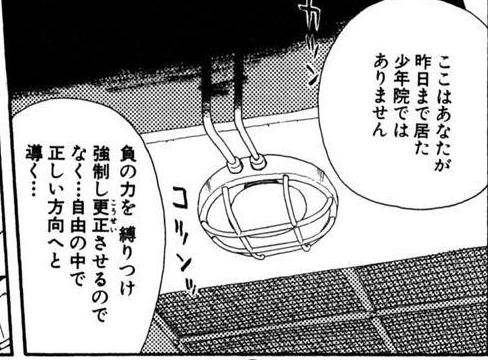

Original Text:
ここはあなたが昨日まで居た少年院ではありません

Context/Panel Caption:
ネットにキスをしているようなキーホルダーが描かれている

Longer Context/Captions:
人間の脚に絵がかかれていて、その下に犬がいる。座っているスーツ姿の人の足下に猫がいる。ネットにキスをしているようなキーホルダーが描かれている。

DeepL Translations:
This is not the juvenile detention center you were in yesterday.
The keychain is painted to look like a kiss on the net. 'This is not the juvenile detention center you were in yesterday.
There is a picture on a human leg and a dog under it. There is a cat under the feet of a person in a sitting suit. There is a keychain painted on a net that looks like a kiss. This is not the juvenile detention center you were in yesterday."

ChatGPT Translations:
"This is not the juvenile detention center you were in until yesterday."
"This is not the juvenile detention center you were in until yesterday."
"This is not the juvenile detention center where you were until yesterday."

Original Text:
負の力を縛りつけ強制し更正させるのでなく…自由の中で正しい方向へと導く…

Context/Panel Caption:
ネットにキスをしているようなキーホルダーが描かれている

Longer Con

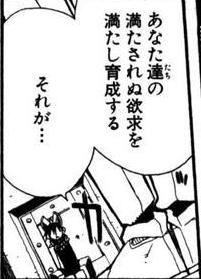

Original Text:
それが…

Context/Panel Caption:
アニメのキャラクターが映し出されている

Longer Context/Captions:
座っているスーツ姿の人の足下に猫がいる。ネットにキスをしているようなキーホルダーが描かれている。アニメのキャラクターが映し出されている。

DeepL Translations:
That's..."
A cartoon character is shown. It is..."
There is a cat under the feet of a person in a sitting suit. A keychain that looks like a kiss is drawn on the net. A cartoon character is projected on it. It is..."

ChatGPT Translations:
"That is..."
"That's it..."
"That's... "

Original Text:
あなた達の満たされぬ欲求を満たし青成する

Context/Panel Caption:
アニメのキャラクターが映し出されている

Longer Context/Captions:
座っているスーツ姿の人の足下に猫がいる。ネットにキスをしているようなキーホルダーが描かれている。アニメのキャラクターが映し出されている。

DeepL Translations:
"I will fulfill your unfulfilled desires and make you blue."
The cartoon characters are projected on the screen. "I will fulfill your unfulfilled desires and make you blue."
There is a cat under the feet of a person in a sitting suit. A keychain that looks like a kiss is drawn on the net. A cartoon character is projected on the screen. It s

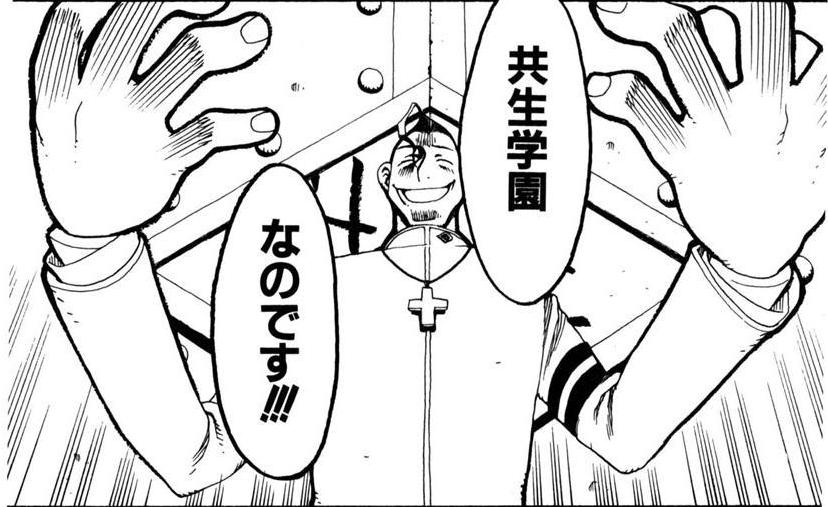

Original Text:
共生学園

Context/Panel Caption:
何かをおでこに寄せているように見える男性がいる

Longer Context/Captions:
ネットにキスをしているようなキーホルダーが描かれている。アニメのキャラクターが映し出されている。何かをおでこに寄せているように見える男性がいる。

DeepL Translations:
Symbiosis Academy
A man appears to have something pulled up to his forehead. Symbiosis Academy."
The keychain is depicted as if it were kissing a net. A cartoon character is shown. A man appears to be holding something to his forehead. Symbiosis Academy."

ChatGPT Translations:
"Kyousei Gakuen" - "Symbiosis Academy"
"Kyousei Gakuen"
"Kyousei Gakuen"

Original Text:
なのです!!!

Context/Panel Caption:
何かをおでこに寄せているように見える男性がいる

Longer Context/Captions:
ネットにキスをしているようなキーホルダーが描かれている。アニメのキャラクターが映し出されている。何かをおでこに寄せているように見える男性がいる。

DeepL Translations:
I'm so!
There is a man who appears to be pulling something up to his forehead. "So!!!!"
The keychain is depicted as if it were kissing a net. A cartoon character is shown. A man appears to be holding something to his forehead. It is "So!"

ChatGPT Translations:
"I tel

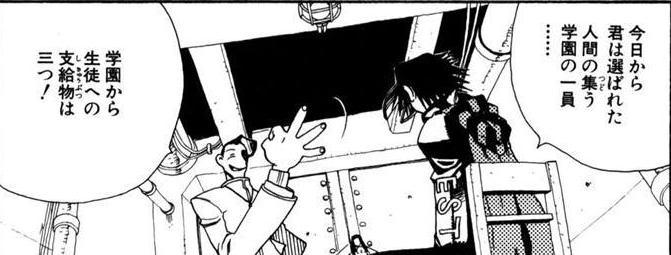

Original Text:
学園から生徒への支給物は三つ！

Context/Panel Caption:
電車の車内で男性が手を挙げている

Longer Context/Captions:
アニメのキャラクターが映し出されている。何かをおでこに寄せているように見える男性がいる。電車の車内で男性が手を挙げている。

DeepL Translations:
The academy provides three items to the students!"
A man raises his hand in a train car. 'The academy supplies the students with three things!'
A cartoon character is shown. A man appears to have something pulled up to his forehead. A man on a train car raises his hand. The man says, "The school has three supplies for the students!"

ChatGPT Translations:
"The supplies provided from the school to the students are three!"
"The three items provided to students from the school are..."
"The school provides three items to students!"

Original Text:
今日から君は選ばれた人間の集う学園の一員……

Context/Panel Caption:
電車の車内で男性が手を挙げている

Longer Context/Captions:
アニメのキャラクターが映し出されている。何かをおでこに寄せているように見える男性がいる。電車の車内で男性が手を挙げている。

DeepL Translations:
"From this day forward, you are a member of a school of chosen people. ......"
A man raises his 

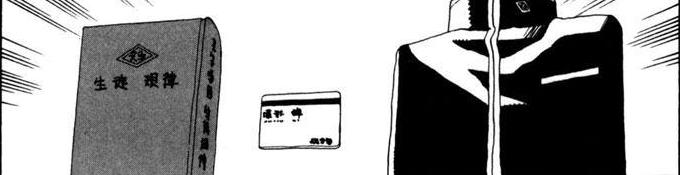

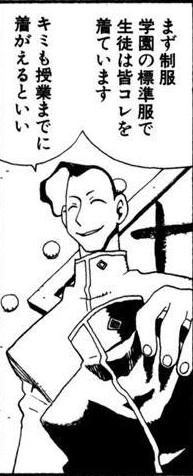

Original Text:
まず制服学国の標準服で生徒は皆コレを着ています

Context/Panel Caption:
携帯電話を持った男性のポスターがある

Longer Context/Captions:
電車の車内で男性が手を挙げている。スーツを着た男の人がうつむいて立っている。携帯電話を持った男性のポスターがある。

DeepL Translations:
First of all, the uniform is the national standard, and all students wear it.
There is a poster of a man holding a cell phone. First of all, the uniform is the national standard, and all students wear this."
A man raises his hand in a train car. A man in a suit stands slumped over. There is a poster of a man holding a cell phone. The man is holding a cell phone and says, "First of all, this is the standard uniform of the school, and all students wear this."

ChatGPT Translations:
"First of all, all students are wearing the standard uniform of the Uniformed Nation."
"First, the students wear the standard uniform of Seifuku Gakukoku, all of them are wearing this."
"The students of Seifuku Gakukoku all wear this as their standard uniform first."

Original Text:
キミも授業までに着がえるといい

Context/Panel Caption:
携帯電話

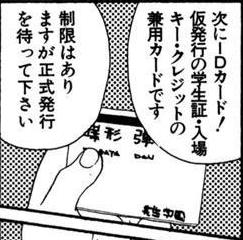

Original Text:
制限はありますが正式発行を待って下さい

Context/Panel Caption:
携帯電話の長さと長さが比較されている

Longer Context/Captions:
スーツを着た男の人がうつむいて立っている。携帯電話を持った男性のポスターがある。携帯電話の長さと長さが比較されている。

DeepL Translations:
There are some restrictions, but please wait for the official issuance."
The length of the phone is compared to the length of the phone. 'There are restrictions, but please wait for official issuance.'
A man in a suit is standing slumped over. There is a poster of a man holding a cell phone. The length of the cell phone is being compared to the length of the . 'Restrictions apply, but please wait for official issuance.'

ChatGPT Translations:
Translation: "There are limitations, but please wait for the official issuance."
"The length and length of mobile phones are being compared. There are restrictions, but please wait for the official release."
"I'm sorry, but there are restrictions. Please wait for the official release."

Original Text:
次にＩＤカード！
仮発行の学生証・入場キー・クレジットの兼用カードです

Context/Panel Caption:
携帯電話の

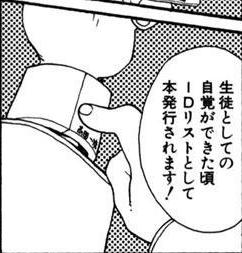

Original Text:
生徒としての自覚ができた頃IDリストとして本発行されます！

Context/Panel Caption:
ネクタイを締めている人のフィギュアがある

Longer Context/Captions:
携帯電話を持った男性のポスターがある。携帯電話の長さと長さが比較されている。ネクタイを締めている人のフィギュアがある。

DeepL Translations:
When you are ready to be a student, you will be issued a book as an ID list!"
There is a figure of a person wearing a tie. When you're ready to be a student, they'll issue you a book as an ID list!"
There is a poster of a man holding a cell phone. The length of the cell phone is compared to the length of the phone. There is a figure of a man wearing a tie. 'When you are ready to be a student, this will be issued to you as an ID list!'

ChatGPT Translations:
"When you become aware of yourself as a student, an ID list will be issued in this issue!"
"When you have developed a sense of awareness as a student, your ID card will be issued as an official document!"
"When you become aware of yourself as a student, this ID list will be issued as a reference!"



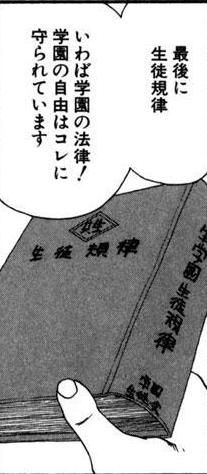

Original Text:
最後に生徒規律

Context/Panel Caption:
ハングル文字が書かれた本を持っている手

Longer Context/Captions:
携帯電話の長さと長さが比較されている。ネクタイを締めている人のフィギュアがある。ハングル文字が書かれた本を持っている手。

DeepL Translations:
Finally, student discipline.
A hand holding a book with Hangul characters. Lastly, student discipline."
The length of the cell phone is compared to the length of the phone. There is a figure of a man wearing a tie. A hand holding a book with Hangul characters. Lastly, student discipline."

ChatGPT Translations:
"Finally, student discipline."
"Finally, the student regulations."
"Finally, student discipline."

Original Text:
いわば学園の法律！学園の自由はコレに守られています

Context/Panel Caption:
ハングル文字が書かれた本を持っている手

Longer Context/Captions:
携帯電話の長さと長さが比較されている。ネクタイを締めている人のフィギュアがある。ハングル文字が書かれた本を持っている手。

DeepL Translations:
"This is the law of the school, so to speak! The freedom of the school is protected by this law."
A hand holding a book with Hangul characters. The laws of the academy, so to speak! The freedom of the academy is protecte

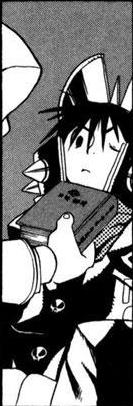

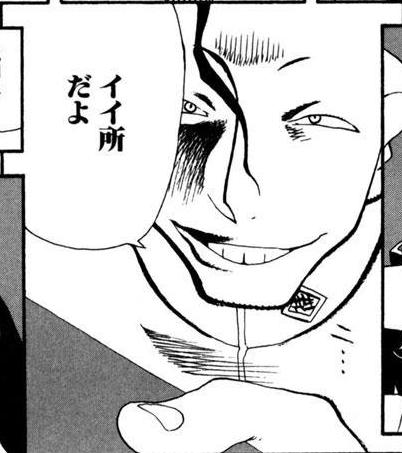

Original Text:
説明は以上

Context/Panel Caption:
携帯電話を持っている人が描かれている

Longer Context/Captions:
ハングル文字が書かれた本を持っている手。アニメのキャラクターが本を持っている。携帯電話を持っている人が描かれている。

DeepL Translations:
That's all.
It depicts a person holding a cell phone. That's all for the description."
A hand holding a book with Hangul characters. A cartoon character is holding a book. A person is shown holding a cell phone. That's all for the explanation."

ChatGPT Translations:
"The explanation is finished."
"The explanation is over."
"The explanation ends here."

Original Text:
イイ所だよ

Context/Panel Caption:
携帯電話を持っている人が描かれている

Longer Context/Captions:
ハングル文字が書かれた本を持っている手。アニメのキャラクターが本を持っている。携帯電話を持っている人が描かれている。

DeepL Translations:
It's a nice place.
It depicts a person holding a cell phone. It's a nice place."
A hand holding a book with Hangul characters. A cartoon character is holding a book. A person is shown holding a cell phone. It's a nice place."

ChatGPT Translations:
"It's a good place."
"It's a nice place."
"It's a good 

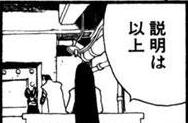

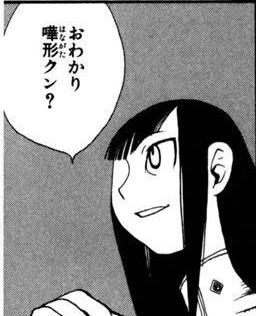

Original Text:
おわかり嘩形クン？

Context/Panel Caption:
アニメのキャラクターが描かれたマウスを女性が見ている

Longer Context/Captions:
携帯電話を持っている人が描かれている。携帯電話で話している男性の後ろ姿。アニメのキャラクターが描かれたマウスを女性が見ている。

DeepL Translations:
Do you understand me, Fighting Kun?
A woman looks at a mouse with a cartoon character on it. Do you see it?
A person is depicted holding a cell phone. Back view of a man talking on a cell phone. A woman is looking at a mouse with a cartoon character on it. The woman is looking at a mouse with a cartoon character on it.

ChatGPT Translations:
"Do you understand, Kagen?"
"Can you recognize this character?"
"Do you understand, Kagata-kun?"



In [24]:
fetch_translations(manga_name='GakuenNoise', pg_num=5)

# Leftover Code from Testing

## Useful Function to Create Directory Structure

In [2]:
import os
import math

def create_folders(directory: str, num_of_folders: int, digits: int):
    """
    Create multiple folders within a directory.
    
    Args:
    - directory: The path of the directory where folders will be created.
    - num_of_folders: The number of folders you want to make.
    """
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # calculate the number of digits
    num_of_folders_digits = int(math.log10(num_of_folders))+1
    if num_of_folders_digits >= digits:
        digits = num_of_folders_digits
    
    # Create folders
    for i in range(1, num_of_folders + 1):
        # create manga panel folders
        panel_folder_name = f"panel{str(i).zfill(digits)}"
        panel_folder_path = os.path.join(directory, panel_folder_name)
        if not os.path.exists(panel_folder_path):
            os.makedirs(panel_folder_path)
            print(f"Folder '{panel_folder_name}' created successfully.")
        else:
            print(f"Folder '{panel_folder_name}' already exists.")
        
        # create the speech folder paths
        speech_folder_name = "speech"
        speech_folder_path = os.path.join(panel_folder_path, speech_folder_name)
        if not os.path.exists(speech_folder_path):
            os.makedirs(speech_folder_path)
            print(f"Speech folder in '{speech_folder_path}' created successfully.")
        else:
            print(f"Speech folder in '{speech_folder_path}' already exists.")

In [4]:
create_folders(directory="New_Game_Vol_11\Ch119", num_of_folders=60, digits=2)

Folder 'panel01' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel01\speech' created successfully.
Folder 'panel02' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel02\speech' created successfully.
Folder 'panel03' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel03\speech' created successfully.
Folder 'panel04' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel04\speech' created successfully.
Folder 'panel05' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel05\speech' created successfully.
Folder 'panel06' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel06\speech' created successfully.
Folder 'panel07' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel07\speech' created successfully.
Folder 'panel08' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel08\speech' created successfully.
Folder 'panel09' created successfully.
Speech folder in 'New_Gam

In [65]:
def translate_manga(manga_directory): 
    start_time = time.time()
    # Get a list of all manga panel directories
    panel_dirs = os.listdir(manga_directory)
    # Iterate through the manga panel directories
    for panel in panel_dirs:
        entry_path = os.path.join(manga_directory, panel)
        
        # Check if it's a directory (you can also check for files if needed)
        if os.path.isdir(entry_path):
            print(f'Subdirectory: {entry_path}')
            
            # set up the dataset for the image captioning software
            caption_generation_dataset = SampleDataset(f'{entry_path}', visual_encoder['eval'])
            display(caption_generation_dataset[0]['raw'])
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            print(f"generated caption: {gen_caption}")
            
            # use ocr for the speech bubbles and then translate it
            
            # set path to speech bubbles
            spch_bbl_entry_path = f'{entry_path}\speech'
            
            for speechbubble in os.listdir(spch_bbl_entry_path):
                # Create the full path to the speechbubble
                png_file_path = os.path.join(spch_bbl_entry_path, speechbubble)
                print(png_file_path)
                # read the text
                recognized_txt = mocr(png_file_path)
                print(f'text: {recognized_txt}')
                
                end_time = time.time()
                
                # because of chatgpt's api, the free tier restricts you to 3 api calls per minute
                # before we ask chatgpt to translate the text, we make sure that it is within 
                # 20 seconds so we don't exceed the free tier's restrictions
                # api_constraints = 20 seconds
                elapsed_time = end_time - start_time
                print(f"elapsed time: {elapsed_time}")
                if elapsed_time < api_constraints:
                    print(f"pausing {api_constraints - elapsed_time}s before next api call")
                    time.sleep(api_constraints - elapsed_time)
                
                prompt = (f"Here is the context of a manga panel: {gen_caption}." 
                        f"Translate this character's dialogue with this context in mind: 「{recognized_txt}」")
                
                translation = get_completion(prompt)
                print(f"translation: {translation}")
                
                start_time = time.time() # update start_time for the next poential translation
        
    
    

Subdirectory: test_dataset\panel001


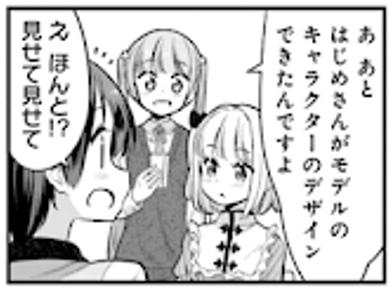

generated caption: 二人の女性が話し合っている様子が映っている
test_dataset\panel001\speech\speech1.PNG
text: ああとはじめさんがモデルのキャラクターのデザインできたんですよ
elapsed time: 32.99495244026184
translation: "Oh, and Hajime-san was able to design the character for the model."
test_dataset\panel001\speech\speech2.PNG
text: えほんと！？現せて見せて
elapsed time: 0.7286884784698486
pausing 19.27131152153015s before next api call
translation: "Really!? Show me, let me see it!"
Subdirectory: test_dataset\panel002


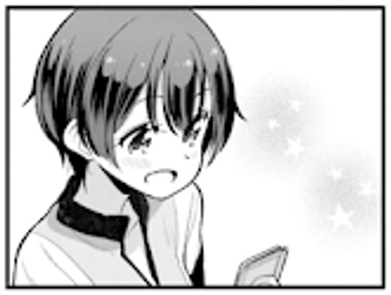

generated caption: 女性が手に持った携帯電話を見ている
Subdirectory: test_dataset\panel003


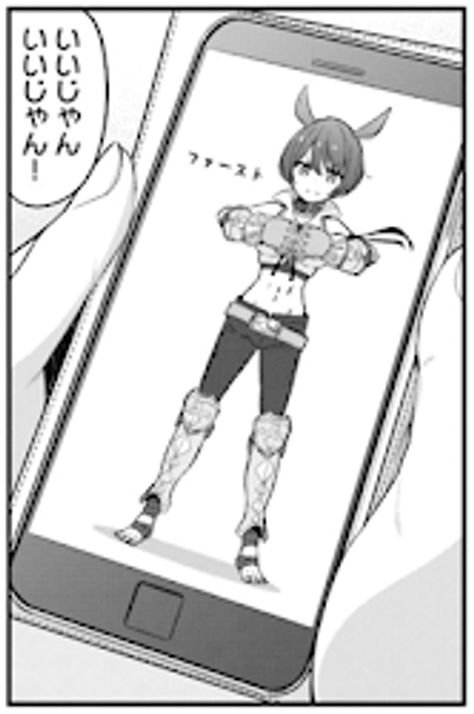

generated caption: 携帯電話を持っているアニメのポスター
test_dataset\panel003\speech\speech1.PNG
text: いいじゃんいいしゃん．．．
elapsed time: 53.30844235420227
translation: "It's fine, it's great to have a cellphone like this... "
Subdirectory: test_dataset\panel004


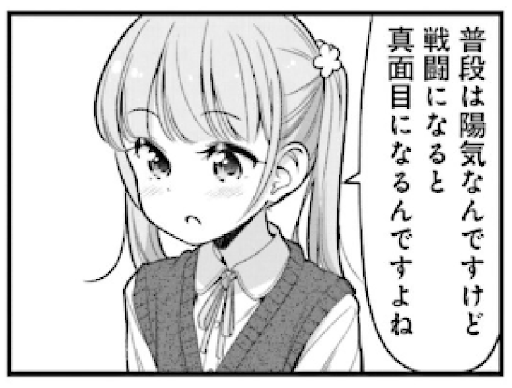

generated caption: ネクタイを締めた髪の長い女性の絵が飾ってある
test_dataset\panel004\speech\speech.png
text: 普段は陽気なんですけど戦闘になると真面目になろうですよね
elapsed time: 31.28185224533081
translation: "In general, I am cheerful, but when it comes to battles, I become serious, don't I?"


In [66]:
translate_manga(manga_directory='test_dataset')

In [1]:
caption_generation_dataset = SampleDataset('./test_content', visual_encoder['eval'])
test_panel = "./test_content/mangapanel.png"

gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
print(f"generated caption: {gen_caption}")
print(f"translated caption: {translator(gen_caption)}")
# normal panel
text = mocr(test_panel)
print(f"uncropped text: {text}")

trns_text = translator(text, max_length=max_len_limit)
print(f"trns_uncroptext{trns_text}")

# cropped panel
croptext = mocr("./test_content/mangapanelcrop.png")
print(f"normal_text: {croptext}")

final_text = gen_caption + "。" + croptext[:-1]

trns_croptext = translator(croptext, max_length=max_len_limit)
print(f"trns_croptext: {trns_croptext}")

print(f"final translated text: {translator(final_text, max_length=max_len_limit)}")

final_text_cont = "場面： "+ gen_caption + "。" + "登場人物の言ったこと： 「" + croptext[:-1] + "」"
print(f"finaler translated text: {translator(final_text_cont, max_length=max_len_limit)}")


NameError: name 'SampleDataset' is not defined

In [10]:
prompt = f"Translate this text to english: {final_text_cont}"
response = get_completion(prompt)
print(f"chatgpt translation: {response}")
time.sleep(api_constraints)

prompt = f"Translate this text to english: {final_text}"
response = get_completion(prompt)
print(f"chatgpt 2nd translation: {response}")
time.sleep(api_constraints)

prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the character from that same manga panel said: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 3rd translation: {response}")
time.sleep(api_constraints)

NameError: name 'final_text_cont' is not defined

In [36]:
gen_caption = "女性たちは登場人物の性格について読んで説明している。"
prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the girl from that same manga panel said about the character: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 4th translation: {response}")
time.sleep(api_constraints)

chatgpt 4th translation: The girl from the manga panel said, "Normally, he's cheerful, but when it comes to battles, he becomes serious, right?"
